# Examples and Demonstrations

The following examples provide a few samples of 
some of the possibilities available when working with music21.

We start loading music21 like this:


In [1]:
# ignore this
%load_ext music21.ipython21
from music21 import *

## Creating a Reduction and Labeling Intervals

Let's load up a score that happens to be in a bunch of parts:

In [2]:
o = corpus.parse('josquin/laDeplorationDeLaMorteDeJohannesOckeghem')
len(o.scores)

5

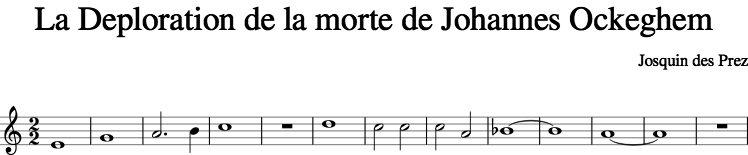

In [3]:
o.scores[0].measures(1, 13).show()

We can merge the scores into a single Score with `.mergeScores` 

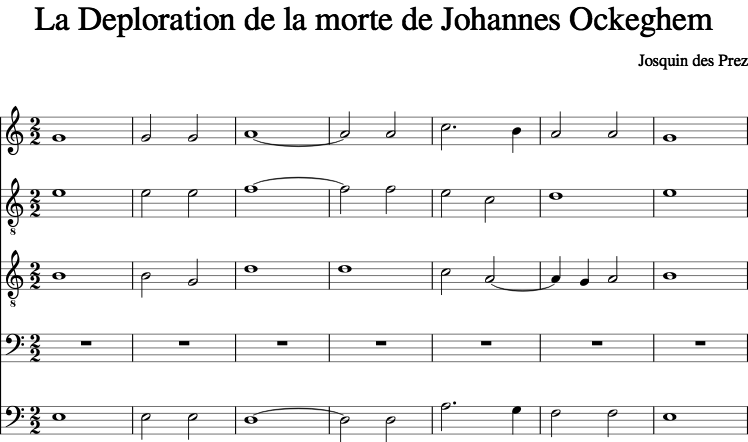

In [4]:
mergedScores = o.mergeScores()
scoreExcerpt = mergedScores.measures(127, 133)
scoreExcerpt.show()

In [5]:
reduction = scoreExcerpt.chordify()

Iterate over the Chords and prepare presentation:

In [6]:
for c in reduction.recurse().getElementsByClass('Chord'):
    c.closedPosition(forceOctave=4, inPlace=True)
    c.annotateIntervals()

Add the reduction and display the results

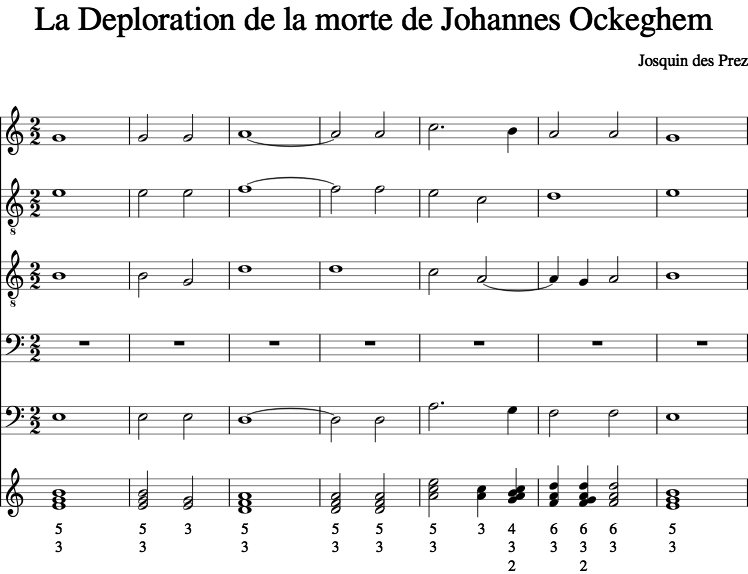

In [7]:
scoreExcerpt.insert(0, reduction)
scoreExcerpt.show()

## Searching a Large Collection of Works for Ultimate Chord Quality

This example search the entire collection of Bach Chorales stored in the corpus
for works that, while in a minor key, end on a minor triad (as opposed to with
the more common raised Picardy third).

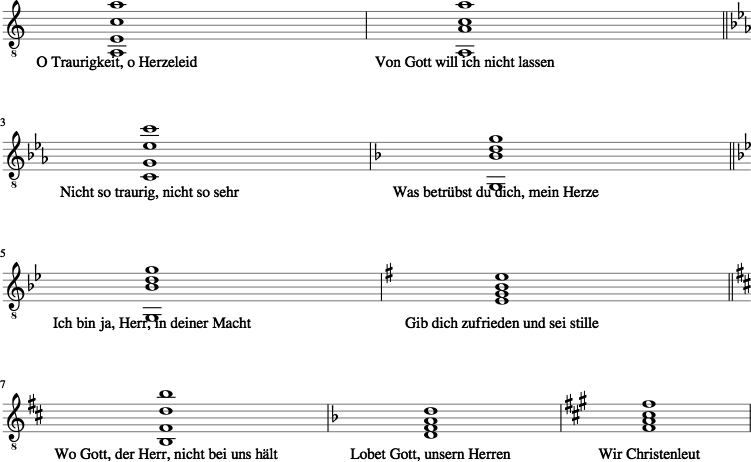

In [8]:
results = stream.Stream()
results.insert(0, clef.Treble8vbClef())

# Get file paths to all Chorales
for chorale in corpus.chorales.Iterator():
    keyObj = chorale.analyze('key')
    
    # Select minor-mode chorales only:
    if keyObj.mode != 'minor':
        continue
        
    # Gather last pitches from all parts into a Chord
    lastChordPitches = []
    for part in chorale.parts:
        lastChordPitches.append(part.flat.pitches[-1])
    
    cLast = chord.Chord(lastChordPitches)
    
    # If it's not a minor triad, skip:
    if not cLast.isMinorTriad() and not cLast.isIncompleteMinorTriad():
        continue
        
    # otherwise, append it to the results with annotations:
    cLast.duration.type = "whole"
    cLast.lyric = chorale.metadata.title
    
    # put the chord in a measure and put that in the results
    m = stream.Measure()
    m.keySignature = chorale.recurse().getElementsByClass('KeySignature')[0]
    m.append(cLast)
    
    results.append(m)
    
# accidentals are probably wrong because of the context.
results.makeAccidentals(inPlace=True)
results.show()

## Searching the Corpus by Locale

This example searches all works in the corpus from two regions in China for the
count and percentage of melodic sevenths. These works come from the Essen
Folksong database, indexed and stored in the `music21` corpus.

In [9]:
# Get an analysis tool
diversityTool = analysis.discrete.MelodicIntervalDiversity()

# get a list to store results.
results = []

In [10]:
# Iterate over two regions
for region in ('shanxi', 'fujian'):
    # Create storage units
    intervalDict = {}
    workCount = 0
    intervalCount = 0
    seventhCount = 0
    
    # Perform a location search on the corpus and iterate over 
    # resulting file name and work number
    for result in corpus.search(region, field='locale'):
        workCount += 1
    
        # Parse the work and create a dictionary of intervals
        s = result.parse()
        intervalDict = diversityTool.countMelodicIntervals(s, found=intervalDict)
    
    # Iterate through all intervals, and count totals and sevenths
    for label in intervalDict.keys():
        intervalCount += intervalDict[label][1] 
        if label in ['m7', 'M7']:
            seventhCount += intervalDict[label][1]
    
    # Calculate a percentage and store results
    pcentSevenths = round((seventhCount / float(intervalCount) * 100), 4)
    results.append((region, pcentSevenths, intervalCount, workCount))

In [11]:
# print results
for region, pcentSevenths, intervalCount, workCount in results: 
    print('locale: {}: found {} percent melodic sevenths, '
          'out of {} intervals in {} works'.format(
              region, pcentSevenths, intervalCount, workCount))

locale: shanxi: found 3.1994 percent melodic sevenths, out of 4282 intervals in 77 works
locale: fujian: found 0.7654 percent melodic sevenths, out of 2613 intervals in 53 works


## Pitch and Duration Transformations

This example creates a mensural canon from the Soprano part of a Bach chorale.
The procedure extracts the :class:`~music21.note.Note` objects from the parsed
:class:`~music21.stream.Score` object, using the :func:`~music21.corpus.parse`
function and the :meth:`~music21.stream.Stream.getElementById` method. Then, a
new part Stream is created by first scaling the timing and duration of events
with the :meth:`~music21.stream.Stream.augmentOrDiminish` method and then
transposing the pitches with the :meth:`~music21.stream.Stream.transpose`
method. The modified Stream is then inserted into another Stream and displayed
with the :meth:`~music21.base.Music21Object.show` method.

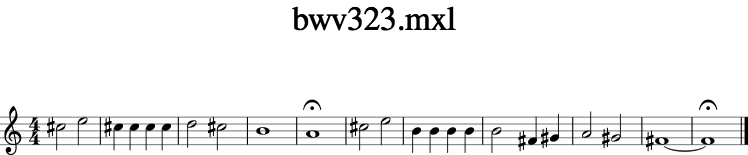

In [12]:
src = corpus.parse('bach/bwv323.xml')
soprano = src.getElementById('Soprano').recurse().notesAndRests.stream()
soprano.show()

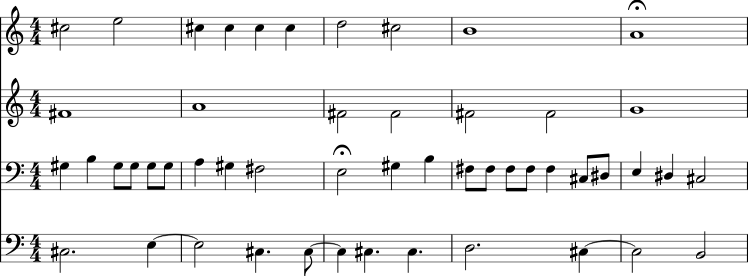

In [13]:
outputScore = stream.Score()

transformations = [(1.0, 'P1'),
                   (2.0, '-P5'),
                   (0.5, '-P11'),
                   (1.5, -24), # 24 semitones down
                  ]

for speed, transposition in transformations:
    part = soprano.augmentOrDiminish(speed)
    part.transpose(transposition, inPlace=True)
    outputScore.insert(0, part)
    
outputScore.measures(1, 5).show()

## Basic Counting of and Searching for Musical Elements

Here, we load a file and count the number of G#'s in it.  It features the use of the `pitches` property which gets all Pitch objects from all contained Streams and Stream subclasses recursively:

In [14]:
s = corpus.parse("bach/bwv30.6")
totalGSharps = 0

for p in s.pitches:
    if p.name == 'G#':
        totalGSharps += 1

print(totalGSharps)

28


Now let's do something a bit more difficult, we'll look for all successive four-note segments (excluding repeated notes) within a measure to see the measure expresses melodically a dominant seventh chord. 

To do this, we'll need to know about the `.findConsecutiveNotes` function.  Let's find a measure with a lot of notes in it to demonstrate:

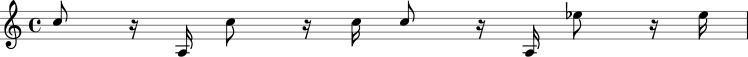

In [23]:
for m in violin2.getElementsByClass('Measure'):
    if len(m.notes) >= 8:
        break
m.show()

The `findConsecutiveNotes` function can find just changes in note name from the previous.  

In [24]:
foundNotes = m.findConsecutiveNotes(skipUnisons=True, skipOctaves=True, 
                                    skipRests=True, noNone=True)
foundNotes

[<music21.note.Note C>,
 <music21.note.Note A>,
 <music21.note.Note C>,
 <music21.note.Note A>,
 <music21.note.Note E->]

Okay, I think we have enough information to understand the code now:

In [25]:
display = stream.Stream()

for m in violin2.getElementsByClass('Measure'):
    foundNotes = m.findConsecutiveNotes(skipUnisons=True, skipOctaves=True, 
                                        skipRests=True, noNone=True)
    
    # From this collection of Notes we gather all Pitches
    foundPitches = stream.Stream(foundNotes).pitches

    # skip ahead if there aren't the right number of pitches for a dominant seventh
    if len(foundPitches) != 4:
        continue


    # make it into a chord.
    c = chord.Chord(foundPitches)
    
    if c.isDominantSeventh() is False:
        continue

    # now lets label the chord:
    c.lyric = "m. {}".format(m.number)
    c.duration.type = 'whole'
        
    
    cClosed = c.closedPosition()
    measureForChord = stream.Measure()
    measureForChord.append(cClosed)
    
    display.append(measureForChord)
    display.append(m)

Okay, let's see what we found!

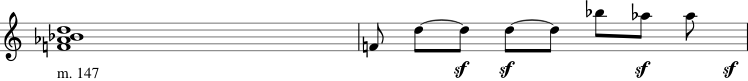

In [26]:
display.show()